# Treinamento do Modelo

Neste notebook, realizamos o treinamento de múltiplos modelos de classificação utilizando Grid Search para encontrar os melhores hiperparâmetros. Após a seleção do modelo com melhor desempenho, avaliamos sua performance no conjunto de teste e salvamos o modelo final.

### Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.sparse import load_npz
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import shap

/home/vlsm/miniconda3/envs/ligia-challenge-NLP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carregando os Dados Processados

In [3]:
data_path = Path("../data/processed")

# Carregar matrizes de features
X_train = load_npz(data_path / "X_train.npz")
X_val = load_npz(data_path / "X_val.npz")
X_test = load_npz(data_path / "X_test.npz")

# Carregar labels
y_train = pd.read_csv(data_path / "y_train.csv")["label"].values
y_val = pd.read_csv(data_path / "y_val.csv")["label"].values
y_test = pd.read_csv(data_path / "y_test.csv")["label"].values

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (16447, 248497)
X_val shape: (4112, 248497)
X_test shape: (2285, 248497)
y_train shape: (16447,)


### Definição dos Modelos e Hiperparâmetros

Configuramos quatro modelos de classificação com suas respectivas grades de hiperparâmetros para otimização via Grid Search:

**Sobre os hiperparâmetros selecionados:**

Para cada modelo, definimos uma grade de hiperparâmetros que explora diferentes configurações:

- **Regularização (C, alpha):** Controla a complexidade do modelo. Valores menores aplicam regularização mais forte (modelo mais simples), enquanto valores maiores permitem maior flexibilidade.
- **Funções de perda:** Testamos diferentes funções de perda (hinge, log_loss, modified_huber) para encontrar a mais adequada aos dados.
- **Class weight:** Comparamos pesos balanceados e uniformes para lidar com possível desbalanceamento de classes.
- **Penalidades:** Exploramos L1, L2 e ElasticNet para controlar overfitting e promover esparsidade quando necessário.

As faixas de valores foram escolhidas para cobrir desde modelos mais conservadores até mais flexíveis, equilibrando desempenho e custo computacional.

In [4]:
param_grid = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=2000, solver="liblinear"),
        'params': {
            'C': [0.01, 0.1, 1.0, 3.0, 10],
            'max_iter': [1000, 2000],
            'class_weight': [None, "balanced"],
        }
    },
    'Linear SVC': {
        'model': LinearSVC(random_state=42),
        'params': {
            'C': [0.01, 0.1, 1.0, 3.0, 10],
            'loss': ["hinge", "squared_hinge"],
            'class_weight': [None, "balanced"],
        }
    },
    'SGD Classifier': {
        'model': SGDClassifier(random_state=42),
        'params': {
            'loss': ["hinge", "log_loss", "modified_huber"],
            'alpha': [1e-5, 1e-4, 1e-3],
            'penalty': ['l2', 'l1', 'elasticnet'],
            'l1_ratio': [0.15, 0.5, 0.85],
            'class_weight': [None, "balanced"],
        }
    },
    'Multinomial NB': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
            'fit_prior': [True, False],
        }
    }
}

print(f"Modelos configurados: {list(param_grid.keys())}\n")

Modelos configurados: ['Logistic Regression', 'Linear SVC', 'SGD Classifier', 'Multinomial NB']



### Treinamento com Grid Search

O Grid Search é executado para todos os modelos, testando todas as combinações de hiperparâmetros definidas. Para garantir robustez e evitar overfitting, utilizamos:

- **Cross-validation de 5 folds:** Divide o conjunto de treinamento em 5 partes, treinando e validando em combinações diferentes.
- **Métrica F1-Score:** Escolhida como métrica principal por ser equilibrada, considerando tanto falsos positivos quanto falsos negativos, ideal para dados com possível desbalanceamento de classes.

Após o treinamento, cada modelo é avaliado no conjunto de validação para comparar o desempenho real.

In [5]:
# Executando o Grid Search para cada modelo
results = {}

for model_name, config in param_grid.items():
    print(f'Treinando {model_name}...')
    
    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_train, y_train)
    results[model_name] = grid
    
    # Predições no validation set
    y_pred = grid.best_estimator_.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    
    print(f'  Best F1 Score (CV): {grid.best_score_:.4f}')
    print(f'  F1 Score (Validation): {f1:.4f}')
    print(f'  Melhores parâmetros: {grid.best_params_}')
    print()

# Resumo dos melhores modelos
print("\n" + "="*60)
print("RESUMO DOS MELHORES RESULTADOS")
print("="*60 + "\n")

for model_name, grid in results.items():
    y_pred = grid.best_estimator_.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    print(f"{model_name}:")
    print(f"  F1 Score (Validation): {f1:.4f}")
    print(f"  Melhores parâmetros: {grid.best_params_}")
    print(f"  Relatório de classificação:")
    print(classification_report(y_val, y_pred))
    print()


Treinando Logistic Regression...
  Best F1 Score (CV): 0.9911
  F1 Score (Validation): 0.9952
  Melhores parâmetros: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000}

Treinando Linear SVC...
  Best F1 Score (CV): 0.9933
  F1 Score (Validation): 0.9952
  Melhores parâmetros: {'C': 3.0, 'class_weight': None, 'loss': 'hinge'}

Treinando SGD Classifier...
  Best F1 Score (CV): 0.9972
  F1 Score (Validation): 0.9976
  Melhores parâmetros: {'alpha': 1e-05, 'class_weight': None, 'l1_ratio': 0.85, 'loss': 'hinge', 'penalty': 'elasticnet'}

Treinando Multinomial NB...
  Best F1 Score (CV): 0.9546
  F1 Score (Validation): 0.9562
  Melhores parâmetros: {'alpha': 0.01, 'fit_prior': True}


RESUMO DOS MELHORES RESULTADOS

Logistic Regression:
  F1 Score (Validation): 0.9952
  Melhores parâmetros: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000}
  Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3064
   

### Avaliação no Conjunto de Teste

Após otimizar os hiperparâmetros com base no conjunto de validação, selecionamos o modelo com melhor desempenho e o avaliamos no conjunto de teste. Essa etapa final é crucial para verificar a capacidade de generalização do modelo em dados completamente novos, não vistos durante o treinamento e a validação.

A matriz de confusão abaixo mostra a distribuição dos acertos e erros do modelo selecionado.

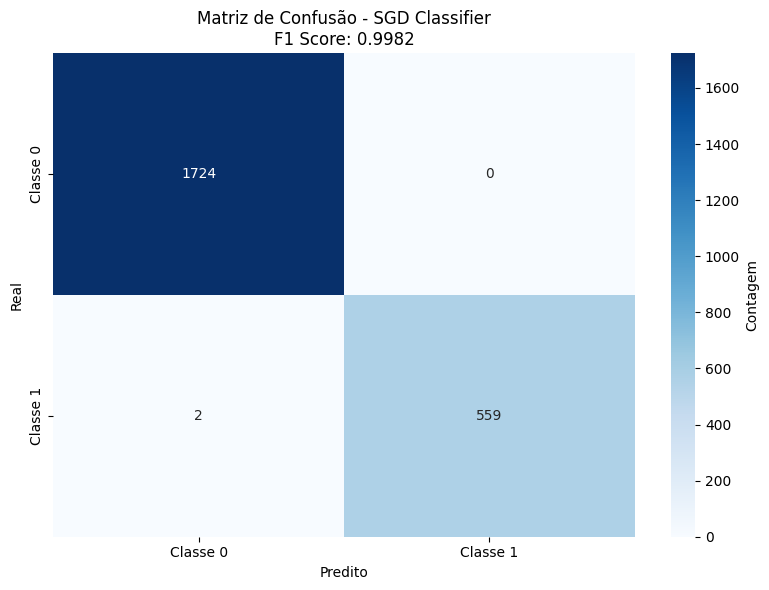

In [6]:
best_overall_model_name = None
best_overall_grid = None
best_overall_f1 = -1

for model_name, grid in results.items():
    y_pred = grid.best_estimator_.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_overall_f1:
        best_overall_f1 = f1
        best_overall_grid = grid
        best_overall_model_name = model_name

# Gerar matriz de confusão
y_pred_best = best_overall_grid.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'],
            cbar_kws={'label': 'Contagem'})
plt.title(f'Matriz de Confusão - {best_overall_model_name}\nF1 Score: {best_overall_f1:.4f}')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.tight_layout()
plt.show()

### Interpretabilidade

Nesta etapa, a interpretabilidade foi feita com **SHAP** (SHapley Additive Explanations), que atribui a cada feature (palavras e n-gramas de caracteres) uma contribuicao para a predicao do modelo. O grafico de resumo (summary plot) mostra, no eixo x, o impacto das features na saida do classificador e, nas cores, a intensidade do valor daquela feature.

**Resultado:** o grafico evidencia quais tokens mais influenciam as decisoes do modelo. Features com valores positivos empurram a predicao para a classe positiva, enquanto valores negativos puxam para a classe oposta. Isso permite identificar o vocabulario que mais pesa nas decisoes e validar se o modelo esta aprendendo sinais coerentes com o dominio.

Esse gráfico nos mostra que fatores linguísticos tem grande influência na decisão do modelo, comportamento esperado de fake news. Fora fatores linguísticos, as maiores influências estão em termos mais populares na mídia, como reuters e obama, indicando que o modelo também é muito influenciado pelo contexto dos dados. 

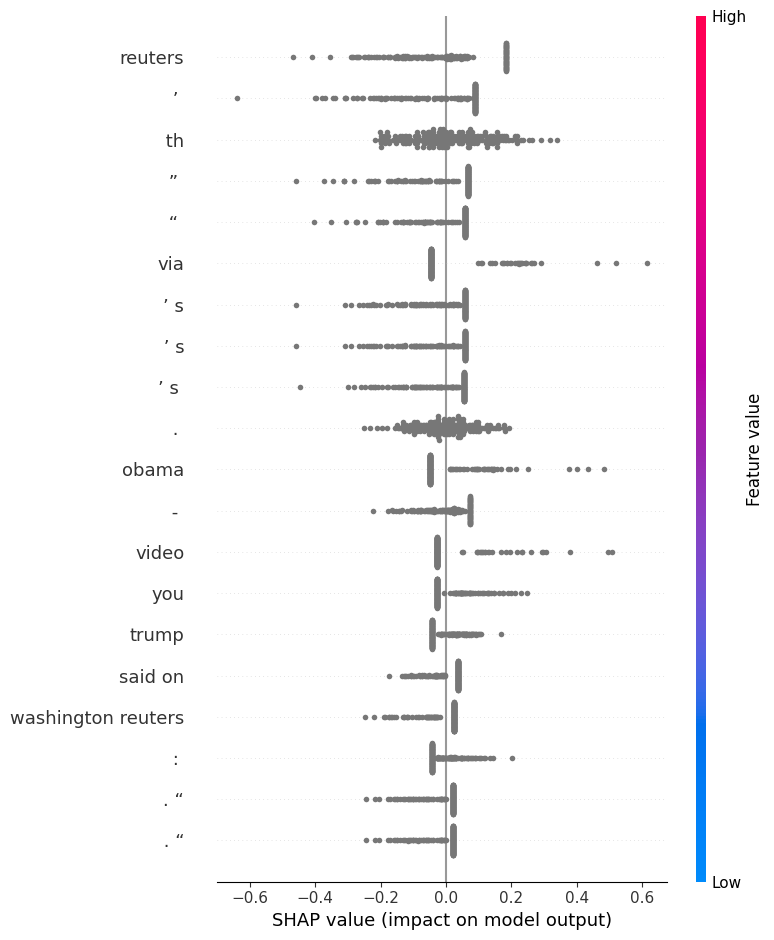

In [ ]:
model = best_overall_grid.best_estimator_

# Carregar vetorizadores para nomes das features
vectorizer_word = globals().get("vectorizer_word")
vectorizer_char = globals().get("vectorizer_char")

if vectorizer_word is None or vectorizer_char is None:
    word_path = Path("../models/vectorizer_word.joblib")
    char_path = Path("../models/vectorizer_char.joblib")
    if word_path.exists() and char_path.exists():
        vectorizer_word = joblib.load(word_path)
        vectorizer_char = joblib.load(char_path)

if vectorizer_word is None or vectorizer_char is None:
    print("Vetorizadores nao encontrados. Rode o notebook 2 para salvar os vetorizadores.")
else:
    feature_names = np.concatenate([
        vectorizer_word.get_feature_names_out(),
        vectorizer_char.get_feature_names_out()
    ])

    # Amostra para background e explicacao para reduzir custo
    rng = np.random.default_rng(42)
    bg_size = min(200, X_train.shape[0])
    ex_size = min(200, X_val.shape[0])
    bg_idx = rng.choice(X_train.shape[0], size=bg_size, replace=False)
    ex_idx = rng.choice(X_val.shape[0], size=ex_size, replace=False)

    X_background = X_train[bg_idx]
    X_explain = X_val[ex_idx]

    if hasattr(model, "coef_"):
        try:
            explainer = shap.LinearExplainer(model, X_background, feature_names=feature_names)
        except TypeError:
            explainer = shap.LinearExplainer(model, X_background)
    else:
        def model_output(x):
            if hasattr(model, "predict_proba"):
                return model.predict_proba(x)
            return model.decision_function(x)

        explainer = shap.Explainer(model_output, X_background, feature_names=feature_names)

    try:
        shap_values = explainer(X_explain)
    except Exception:
        shap_values = explainer.shap_values(X_explain)

    # Para classificacao binaria, usar classe positiva quando aplicavel
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[1], X_explain, feature_names=feature_names, show=True)
    else:
        shap.summary_plot(shap_values, X_explain, feature_names=feature_names, show=True)

### Salvamento do Modelo Final

O melhor modelo treinado é salvo em formato `.joblib` para uso futuro em produção ou para geração de predições em novos dados.

In [ ]:
joblib.dump(best_overall_grid.best_estimator_, '../models/best_model.joblib')

['../models/best_model.joblib']